In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import sklearn
import pickle

from utils_ridge import (
    GD, 
    RR_SVRG, 
    RR_VR,
    L_SVRG,
    SVRG,
    CYCLIC_SVRG,
    SO_SVRG,
    RR_SGD,
    SAGA_RR,
    SAGA
)
from ridge import optimal_rigde
np.random.seed(1)
random.seed(1)

In [2]:
def load_data(path, normalize = True):
    A, y = datasets.load_svmlight_file(path)
    A = A.toarray()
    if (normalize == True):
        A = sklearn.preprocessing.normalize(A, norm="l2")
    n = A.shape[0]
    d = A.shape[1]
    return A, y, n, d

def compute_constants(A, y, n, d, lambd):
    eigvals, _ = np.linalg.eigh(np.transpose(A)@A)
    eig_max = max(eigvals)
    eig_min = min(eigvals)
    L = eig_max/n+lambd
    L_i_list = []
    for i in range(n):
        L_i_list.append(np.linalg.norm(A[i,:])**2+lambd)
    mu = eig_min/n+lambd
    L_max = max(L_i_list)
    return L, mu, L_max, L_i_list

In [3]:
algo_func_pair = {
    "L_SVRG": L_SVRG,
    "RR_SGD": RR_SGD,
    "RR_SVRG": RR_SVRG,
    "SVRG": SVRG,
    "SAGA_RR": SAGA_RR,
    "SAGA": SAGA,
    "RR_VR.9": RR_VR,
    "RR_VR.5": RR_VR,
    "RR_VR.95": RR_VR,
    "RR_VR.8": RR_VR,
    "CYCLIC_SVRG": CYCLIC_SVRG,
    "SO_SVRG": SO_SVRG
}

In [17]:
names = {
    "L_SVRG": "L_SVRG",
    "RR_SGD": "RR_SGD",
    "RR_SVRG": "Rand-Reshuffle",
    "SVRG": "SVRG",
    "SAGA_RR": "SAGA_RR",
    "SAGA": "SAGA",
    "RR_VR.9": "RR_VR",
    "RR_VR.5": "RR_VR",
    "RR_VR.95": "RR_VR",
    "RR_VR.8": "RR_VR",
    "CYCLIC_SVRG": "Det-Shuffle",
    "SO_SVRG": "Rand-Shuffle"
}

In [4]:
algo_color_pair = {
    "L_SVRG": 'green',
    "RR": 'brown',
    "RR_SVRG": 'red',
    "SVRG": 'hotpink',
    "SAGA_RR": 'teal',
    "SAGA": 'purple',
    "RR_VR.9": 'navy',
    "RR_VR.5": 'limegreen',
    "RR_VR.95": 'grey',
    "RR_VR.8": 'pink',
    "CYCLIC_SVRG": 'blue',
    "SO_SVRG": 'orange'
}

In [5]:
def main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE):
    A, y, n, d = load_data(DATASET_NAME+".txt", normalize = NORMALIZE)
    if (STR_LAMBDA == '1_n'):
        lambd = 1/n
    elif (STR_LAMBDA == '10_n'):
        lambd = 10/n
    elif (STR_LAMBDA == '1_10n'):
        lambd = 1/10/n
    L, mu, L_max, L_i_list = compute_constants(A, y, n, d, lambd)
    print("n = {}, d = {}, L = {:.5f}, L_max = {:.5f}, mu = {:.5f}, kappa = {:.5f}".format(n, d, L, L_max, mu, L_max/mu))
    x_star = optimal_rigde(A, y, lambd, n, d)
    return A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star

#### Experiment #2
Comparison of SAGA, SAGA-RR, RR-SVRG, L-SVRG, RR-VR0.5

Dataset: bodyfat, a1a

Algorithms: SAGA, SAGA_RR, RR_SVRG, L_SVRG, RR-VR.5

In [6]:
def myMain(algo_name, A, y, lambd, n, d, stepsize, x_star, iter_num = 100):
    if (algo_name == "RR_VR.9"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.9, max_num_iter = iter_num)        
    if (algo_name == "RR_VR.8"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.8, max_num_iter = iter_num)
    if (algo_name == "RR_VR.5"):
        return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, p = 0.5, max_num_iter = iter_num)    
    return algo_func_pair[algo_name](A, y, lambd, n, d, stepsize, x_star, max_num_iter = iter_num)

In [7]:
algos = ['CYCLIC_SVRG', 'SO_SVRG', 'SVRG', 'RR_SVRG', 'L_SVRG']
DATASET_NAME = "abalone"
NORMALIZE = False
STR_LAMBDA = '10_n'

In [8]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 4177, d = 8, L = 5.60533, L_max = 15.30074, mu = 0.00254, kappa = 6016.07616


In [8]:
stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [9]:
number_of_experiments = 5
number_of_epochs = 30
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        print("experiment=", experiment, "algo=", algo)
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

CYCLIC_SVRG
experiment= 0 algo= CYCLIC_SVRG
0.0892008882326246 CYCLIC_SVRG
0.05946725882174973 CYCLIC_SVRG
0.035680355293049845 CYCLIC_SVRG
experiment= 1 algo= CYCLIC_SVRG
0.0892008882326246 CYCLIC_SVRG
0.05946725882174973 CYCLIC_SVRG
0.035680355293049845 CYCLIC_SVRG
experiment= 2 algo= CYCLIC_SVRG
0.0892008882326246 CYCLIC_SVRG
0.05946725882174973 CYCLIC_SVRG
0.035680355293049845 CYCLIC_SVRG
experiment= 3 algo= CYCLIC_SVRG
0.0892008882326246 CYCLIC_SVRG
0.05946725882174973 CYCLIC_SVRG
0.035680355293049845 CYCLIC_SVRG
experiment= 4 algo= CYCLIC_SVRG
0.0892008882326246 CYCLIC_SVRG
0.05946725882174973 CYCLIC_SVRG
0.035680355293049845 CYCLIC_SVRG
SO_SVRG
experiment= 0 algo= SO_SVRG
0.1784017764652492 SO_SVRG
0.0892008882326246 SO_SVRG
experiment= 1 algo= SO_SVRG
0.0892008882326246 SO_SVRG
0.05946725882174973 SO_SVRG
experiment= 2 algo= SO_SVRG
0.1784017764652492 SO_SVRG
0.0892008882326246 SO_SVRG
experiment= 3 algo= SO_SVRG
0.1784017764652492 SO_SVRG
0.0892008882326246 SO_SVRG
experiment=

In [10]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

CYCLIC_SVRG
SO_SVRG
SVRG
RR_SVRG
L_SVRG


In [11]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.semilogy(results[algo]['grad_comps'][0], error_best[algo], label = algo, marker='*')
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

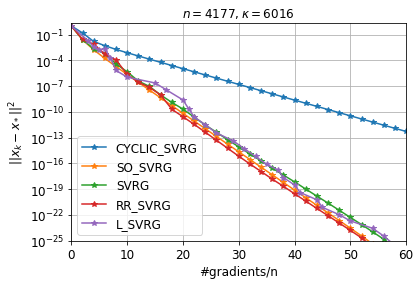

In [12]:
plot_results(results, xlim = 60, ylim=1e-25)

In [254]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_svrg_versions_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_svrg_versions_abalone_not_normalized_lambd_10_n


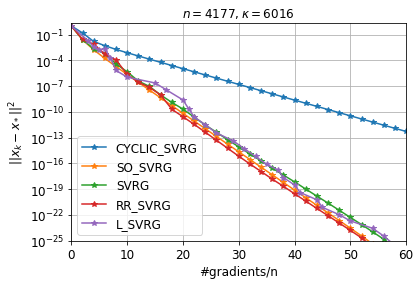

In [171]:
# plot_results(results, xlim = 60, ylim=1e-25, filename=name+'_best.pdf', save=True)

In [172]:
with open('plots/'+name+'.pickle', 'wb') as handle:
    pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)  

In [173]:
print("n {}, kappa {}".format(n, L_max/mu))

n 4177, kappa 6016.076155780063


#### 2nd plot

In [9]:
algos = ['CYCLIC_SVRG', 'SO_SVRG', 'SVRG', 'RR_SVRG', 'L_SVRG']
DATASET_NAME = "abalone"
NORMALIZE = True
STR_LAMBDA = '10_n'

In [10]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 4177, d = 8, L = 0.90035, L_max = 1.00239, mu = 0.00243, kappa = 413.17002


In [257]:
number_of_experiments = 5
number_of_epochs = 30
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        print("experiment=", experiment, "algo=", algo)
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            if (best_error > alg_error[-10]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

CYCLIC_SVRG
experiment= 0 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 1 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 2 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 3 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 4 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
SO_SVRG
experiment= 0 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 1 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 2 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 3 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 4 algo= SO_SVRG
0.1784017764652492 SO_SVRG
SVRG
experiment= 0 algo= SVRG
0.1784017764652492 SVRG
experiment= 1 algo= SVRG
0.1784017764652492 SVRG
experiment= 2 algo= SVRG
0.1784017764652492 SVRG
experiment= 3 algo= SVRG
0.1784017764652492 SVRG
experiment= 4 algo= SVRG
0.1784017764652492 SVRG
RR_SVRG
experiment= 0 algo= RR_SVRG
0.1784017764652492 RR_SVRG
experiment= 1 algo= RR_SVRG
0.1784017764652492 RR_SVRG
experiment= 2 algo= RR

In [258]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

CYCLIC_SVRG
SO_SVRG
SVRG
RR_SVRG
L_SVRG


In [18]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.semilogy(results[algo]['grad_comps'][0], error_averages[algo], label = names[algo], marker='*', markersize=12, color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

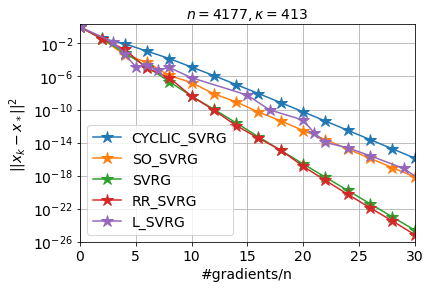

In [277]:
plot_results(results, xlim=30, ylim=1e-26)

In [261]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_svrg_versions_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_svrg_versions_abalone_normalized_lambd_10_n


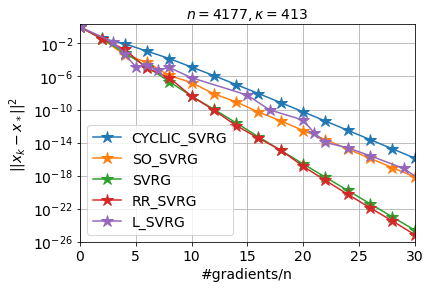

In [278]:
# plot_results(results, xlim=30, ylim=1e-26, filename=name+'_averages.pdf', save=True)  

In [11]:
name = 'ridge_svrg_versions_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

ridge_svrg_versions_abalone_normalized_lambd_10_n
CYCLIC_SVRG
SO_SVRG
SVRG
RR_SVRG
L_SVRG


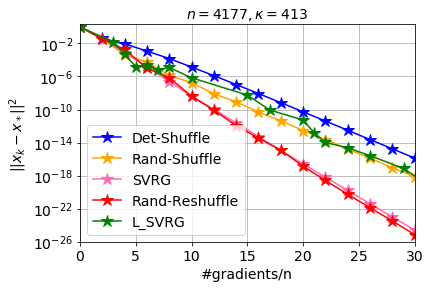

In [19]:
plot_results(in_pickle['results'], xlim=30, ylim=1e-26)

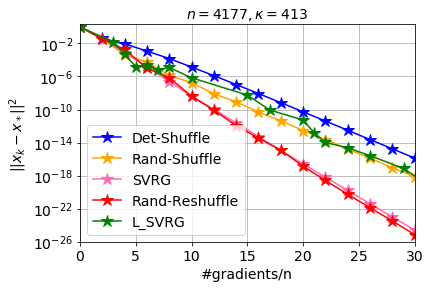

In [20]:
plot_results(in_pickle['results'], xlim=30, ylim=1e-26, filename=name+'_averages_neurips.pdf', save=True)

In [279]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### best plot

In [21]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.semilogy(results[algo]['grad_comps'][0], error_best[algo], label = names[algo], marker='*', markersize=12, color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

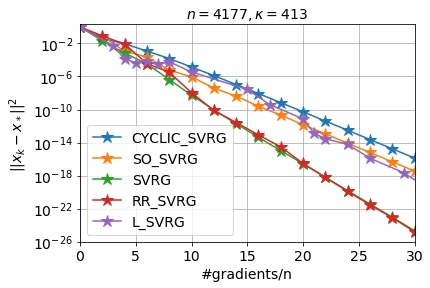

In [281]:
plot_results(results, xlim=30, ylim=1e-26)

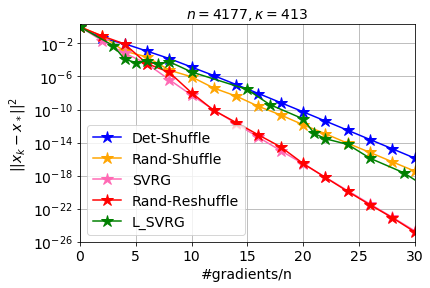

In [22]:
plot_results(in_pickle['results'], xlim=30, ylim=1e-26)

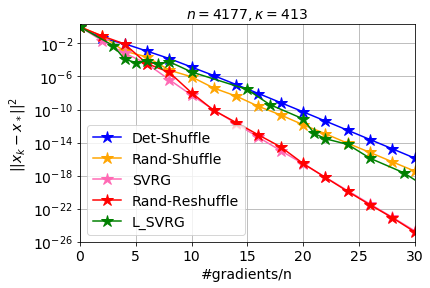

In [23]:
plot_results(in_pickle['results'], xlim=30, ylim=1e-26, filename=name+'_best_neurips.pdf', save=True)  

#### 3rd plot

In [24]:
algos = ['CYCLIC_SVRG', 'SO_SVRG', 'SVRG', 'RR_SVRG', 'L_SVRG']
DATASET_NAME = "a1a"
NORMALIZE = True
STR_LAMBDA = '10_n'

In [25]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 1605, d = 119, L = 0.45807, L_max = 1.00623, mu = 0.00623, kappa = 161.50000


In [285]:
number_of_experiments = 5
number_of_epochs = 30
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        print("experiment=", experiment, "algo=", algo)
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            if (best_error > alg_error[-10]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

CYCLIC_SVRG
experiment= 0 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 1 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 2 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 3 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
experiment= 4 algo= CYCLIC_SVRG
0.1784017764652492 CYCLIC_SVRG
SO_SVRG
experiment= 0 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 1 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 2 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 3 algo= SO_SVRG
0.1784017764652492 SO_SVRG
experiment= 4 algo= SO_SVRG
0.1784017764652492 SO_SVRG
SVRG
experiment= 0 algo= SVRG
0.1784017764652492 SVRG
experiment= 1 algo= SVRG
0.1784017764652492 SVRG
experiment= 2 algo= SVRG
0.1784017764652492 SVRG
experiment= 3 algo= SVRG
0.1784017764652492 SVRG
experiment= 4 algo= SVRG
0.1784017764652492 SVRG
RR_SVRG
experiment= 0 algo= RR_SVRG
0.1784017764652492 RR_SVRG
experiment= 1 algo= RR_SVRG
0.1784017764652492 RR_SVRG
experiment= 2 algo= RR

In [286]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

CYCLIC_SVRG
SO_SVRG
SVRG
RR_SVRG
L_SVRG


In [28]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.semilogy(results[algo]['grad_comps'][0], error_averages[algo], label = names[algo], marker='*', color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

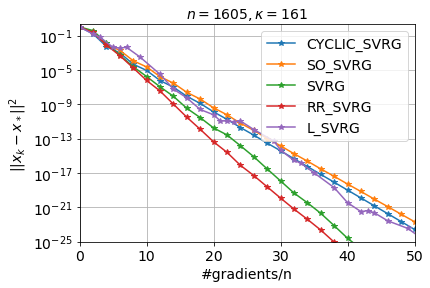

In [289]:
plot_results(results, xlim=50, ylim=1e-25)

In [290]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_svrg_versions_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_svrg_versions_a1a_normalized_lambd_10_n


In [29]:
name = 'ridge_svrg_versions_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)
in_pickle = pickle.load(open("plots/"+name+'.pickle', "rb" ))
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*in_pickle["results"][algo]['error'])]
    error_best[algo] = min(in_pickle["results"][algo]['error'], key=lambda x: x[-1])    

ridge_svrg_versions_a1a_normalized_lambd_10_n
CYCLIC_SVRG
SO_SVRG
SVRG
RR_SVRG
L_SVRG


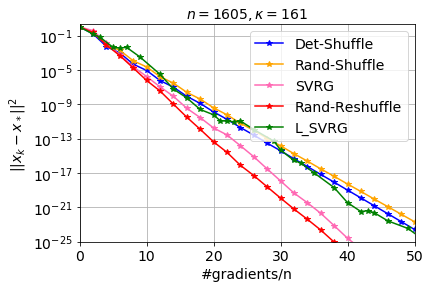

In [30]:
plot_results(in_pickle['results'], xlim=50, ylim=1e-25)

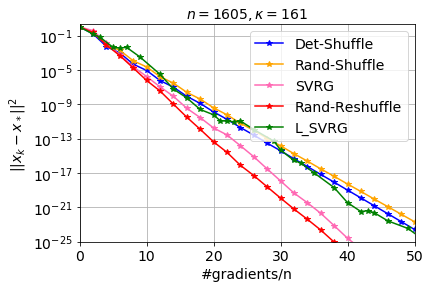

In [31]:
plot_results(in_pickle['results'], xlim=50, ylim=1e-25, filename=name+'_averages_neurips.pdf', save=True)

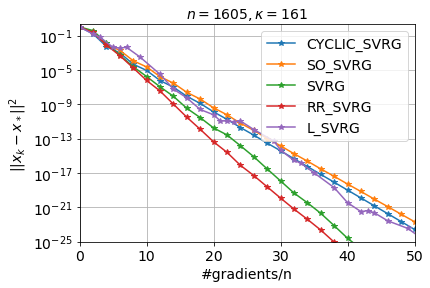

In [291]:
# plot_results(results, xlim=50, ylim=1e-25, filename=name+'_averages.pdf', save=True)

In [292]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### best plot

In [32]:
def plot_results(results, xlim = 50, ylim = 1e-15, save = False, filename = "test.pdf"):
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    for algo in algos:
        plt.semilogy(results[algo]['grad_comps'][0], error_best[algo], label = names[algo], marker='*', color=algo_color_pair[algo])
    plt.xlim(0, xlim)
    plt.title(r"$n={}, \kappa={:.0f} $".format(n, L_max//mu), fontsize=BIGGER_SIZE)
    plt.xlabel("#gradients/n", fontsize = BIGGER_SIZE)
    plt.ylabel(r"$||x_k-x_*||^2$", fontsize = BIGGER_SIZE)
    plt.ylim(ylim, 2)
    plt.legend(fontsize = BIGGER_SIZE)
    plt.grid()
    if save:
        plt.savefig("plots/"+filename, dpi=500, bbox_inches='tight')
    plt.show()
    

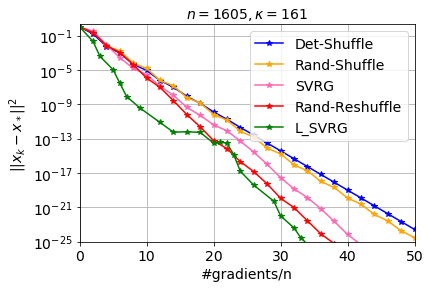

In [33]:
plot_results(in_pickle['results'], xlim=50, ylim=1e-25)

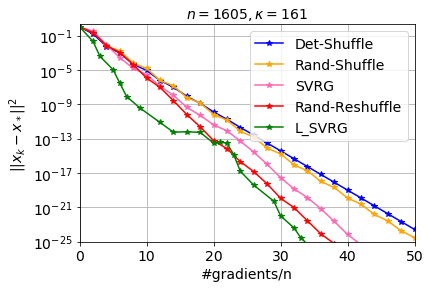

In [34]:
plot_results(in_pickle['results'], xlim=50, ylim=1e-25, filename=name+'_best_neurips.pdf', save=True)  

#### 4th plot

In [91]:
algos = ['SAGA', 'SAGA_RR', 'RR_SVRG', 'L_SVRG', 'RR_VR.5']
DATASET_NAME = "a1a"
NORMALIZE = True
STR_LAMBDA = '1_n'

stepsizes = [1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]
STR_STEPSIZES = '[1/L, 1/2/L, 1/3/L, 1/5/L, 1/10/L]'

In [92]:
A, y, n, d, lambd, L, mu, L_max, L_i_list, x_star = main_settings(DATASET_NAME, STR_LAMBDA, NORMALIZE)

n = 1605, d = 119, L = 0.45246, L_max = 1.00062, mu = 0.00062, kappa = 1606.00000


In [93]:
number_of_experiments = 1
number_of_epochs = 50
results = {}
for algo in algos:
    results[algo] = {}
    results[algo]["error"] = []
    results[algo]["epochs"] = []
    results[algo]["grad_comps"] = []
for algo in algos:
    print(algo)
    for experiment in range(number_of_experiments):
        best_error = 1e5
        best_errors = []
        best_grads = []
        best_epochs = []
        best_grad_comps = []
        for stepsize in stepsizes:
            np.random.seed(experiment)
            random.seed(experiment)
            alg_error, alg_grad, alg_epochs, alg_grad_comps = myMain(algo, A, y, lambd, \
                                                                                 n, d, stepsize, x_star, iter_num = number_of_epochs)
            print(alg_error[-1])
            if (best_error > alg_error[-1]):
                    best_error = alg_error[-1].copy()
                    best_errors = alg_error.copy()
                    best_grads = alg_grad.copy()
                    best_epochs = alg_epochs.copy()
                    best_grad_comps = alg_grad_comps.copy()
                    print(stepsize, algo)
        results[algo]['error'].append(best_errors)
        results[algo]['epochs'].append(best_epochs)    
        results[algo]['grad_comps'].append(best_grad_comps)

SAGA
inf
20378.991878190263
1.1064352856332855 SAGA
1.5212893686107103e-10
0.7376235237555236 SAGA
1.7766860195589213e-17
0.4425741142533142 SAGA
6.378418346475102e-11
SAGA_RR
inf
4466.875007744286
1.1064352856332855 SAGA_RR
6.686343349657577e-13
0.7376235237555236 SAGA_RR
5.0994246265613656e-17
0.4425741142533142 SAGA_RR
4.398645530130565e-10
RR_SVRG
inf
1.2965837369080416e-07
1.1064352856332855 RR_SVRG
5.780054225856013e-23
0.7376235237555236 RR_SVRG
1.2962496353794698e-20
6.263214808522387e-11
L_SVRG
inf
4.896146083473969e-05
1.1064352856332855 L_SVRG
3.3447248762460216e-18
0.7376235237555236 L_SVRG
1.563509742369473e-20
0.4425741142533142 L_SVRG
6.17002591296617e-11
RR_VR.5
3.62807855260792e+283
0.07652537269139181
1.1064352856332855 RR_VR.5
1.523629539769759e-11
0.7376235237555236 RR_VR.5
3.105905292468688e-19
0.4425741142533142 RR_VR.5
6.289497712033237e-11


In [94]:
error_averages = {}
error_best = {}
for algo in algos:
    print(algo)
    error_averages[algo] = [sum(col) / float(len(col)) for col in zip(*results[algo]['error'])]
    error_best[algo] = min(results[algo]['error'], key=lambda x: x[-1])

SAGA
SAGA_RR
RR_SVRG
L_SVRG
RR_VR.5


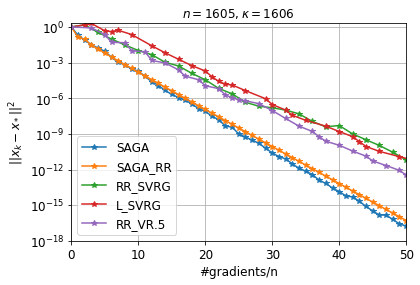

In [101]:
plot_results(results, xlim=50, ylim=1e-18)

In [102]:
save_info = {
    "dataset": DATASET_NAME,
    "regularizer": STR_LAMBDA,
    "normalized": NORMALIZE,
    "problem": "ridge",
    "algos": algos,
    "algo_function_pair": algo_func_pair,
    "results": results,
    "number_of_experiments": number_of_experiments,
    "stepsizes": STR_STEPSIZES
}
name = 'ridge_saga_svrg_rr_'+DATASET_NAME
if (NORMALIZE):
    name += "_normalized_"
else:
    name += "_not_normalized_"
name += 'lambd_' + STR_LAMBDA
print(name)

ridge_saga_svrg_rr_a1a_normalized_lambd_1_n


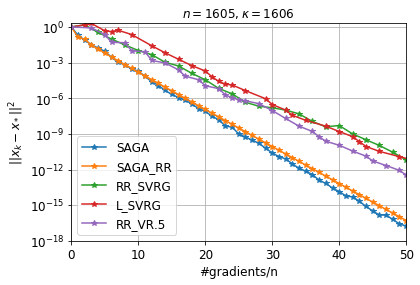

In [103]:
# with open('plots/'+name+'.pickle', 'wb') as handle:
#     pickle.dump(save_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plot_results(results, xlim=50, ylim=1e-18, filename=name+'.pdf', save=True)  